## Multiplicación de matrices utilizando las instrucciones avx
### Arquitectura de computadoras

Alberto Josué Ortiz Rosales          21-Mar-2022

Descripción del problema: Usando las instrucciones avx se desea realizar la multiplicación de matrices, las cuales contienen número de punto flotante de precisión simple.

Resolución para resolverlo se hace uso de los registros SIMD YMM de 256 bits los cuales soportan instrucciones vectoriales AVX. Dentro de estos registros caben 8 elementos de punto flotante de 32 bits.

La función __m256 _mm256_load_ps (float const * mem_addr) del conjunto de instrucciones avx permite realizar la carga de 8 elementos de punto flotante en el registro ymm.

```c
__m256 _mm256_load_ps (float const * mem_addr)
dst[255:0] := MEM[mem_addr+255:mem_addr]
dst[MAX:256] := 0
```

Una vez cargados los datos en dos registros de 256 se puede realizar las operaciones de suma y multiplicación.

```c
__m256 _mm256_add_ps (__m256 a, __m256 b)
FOR j := 0 to 7
	i := j*32
	dst[i+31:i] := a[i+31:i] + b[i+31:i]
ENDFOR
dst[MAX:256] := 0
```

```c
__m256 _mm256_add_ps (__m256 a, __m256 b)
FOR j := 0 to 7
	i := j*32
	dst[i+31:i] := a[i+31:i] + b[i+31:i]
ENDFOR
dst[MAX:256] := 0
```





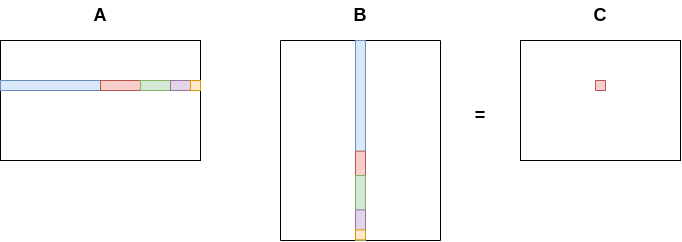

__*Figura 1.*__ Partición de la columna o fila a multiplicar en potencias de 2, azul: múltiplo de 64, rojo: múltiplo de 32, verde: múltiplo de 16, morado: múltiplo de 8, amarillo: residuo 1 - 7.

Dado que las instrucciones utilizadas realizan operaciones en 8 datos. Se decide trabajar en múltiplos de 8 para poder parelelizar las operaciones. La idea es hacer una multiplicación simultanea del elemento i de la fila de la matriz A y el elemento i de la columna de la matriz B para todos los elementos. Finalmente reducir sus componentes a uno solo mediante la addición, el cual será el elemento de la matriz C.

**Fracción del código encargada de realizar las operaciónes en múltiplos de 64**

```c
float res = 0;
			for (int j = 0; j < reduced_64; j += 64)
			{
				// Carga de los datos de la columna de B
				ymm8  = _mm256_loadu_ps(&T[l][j]);
				ymm9  = _mm256_loadu_ps(&T[l][j + 8]);
				ymm10 = _mm256_loadu_ps(&T[l][j + 16]);
				ymm11 = _mm256_loadu_ps(&T[l][j + 24]);
				ymm12 = _mm256_loadu_ps(&T[l][j + 32]);
				ymm13 = _mm256_loadu_ps(&T[l][j + 40]);
				ymm14 = _mm256_loadu_ps(&T[l][j + 48]);
				ymm15 = _mm256_loadu_ps(&T[l][j + 56]);
				// Carga de los datos de la fila de A
				ymm0 = _mm256_loadu_ps(&w[i][j]);
				ymm1 = _mm256_loadu_ps(&w[i][j + 8]);
				ymm2 = _mm256_loadu_ps(&w[i][j + 16]);
				ymm3 = _mm256_loadu_ps(&w[i][j + 24]);
				ymm4 = _mm256_loadu_ps(&w[i][j + 32]);
				ymm5 = _mm256_loadu_ps(&w[i][j + 40]);
				ymm6 = _mm256_loadu_ps(&w[i][j + 48]);
				ymm7 = _mm256_loadu_ps(&w[i][j + 56]);
				// Multiplicacion de la fila por columna
				ymm0 = _mm256_mul_ps(ymm0, ymm8 );
				ymm1 = _mm256_mul_ps(ymm1, ymm9 );
				ymm2 = _mm256_mul_ps(ymm2, ymm10);
				ymm3 = _mm256_mul_ps(ymm3, ymm11);
				ymm4 = _mm256_mul_ps(ymm4, ymm12);
				ymm5 = _mm256_mul_ps(ymm5, ymm13);
				ymm6 = _mm256_mul_ps(ymm6, ymm14);
				ymm7 = _mm256_mul_ps(ymm7, ymm15);
				// Reducción de los productos
				ymm0 = _mm256_add_ps(ymm0, ymm1);
				ymm2 = _mm256_add_ps(ymm2, ymm3);
				ymm4 = _mm256_add_ps(ymm4, ymm5);
				ymm6 = _mm256_add_ps(ymm6, ymm7);
				ymm0 = _mm256_add_ps(ymm0, ymm2);
				ymm4 = _mm256_add_ps(ymm4, ymm6);
				ymm0 = _mm256_add_ps(ymm0, ymm4);

		__builtin_ia32_storeups256(scratchpad, ymm0);
				// reducción final
				for (int k = 0; k < 8; k++)
					res += scratchpad[k];
			}
```

En los registros ymm8 - ymm15 se cargan los datos correspondientes a la columna de la matriz B. Sin embargo esta matriz se tuvo que transponer ya que la operación de carga pide como argumento una dirección de memoria correspondiente a la columna, sin embargo esta columnas no estan guardadas en memoria de manera secuencial como las filas y presentan saltos.

En los registros ymm0 - ymm7 se cargan los datos de la matriz A, filas. Posteriomente se realiza la multiplicación de la fila por la columna, su resultado se guarda nuevamente en un registro de 256. Por lo tanto hay que reducir cada registro mediante sumas hata obtener uno solo. Finalmente se obtiene un solo registro el cual contiene 8 sumas parciales, por lo tanto se tienen que reducir hasta obtener un solo resultado. Debido a esto se se cargan los valores del registro de 256 en un arreglo de 8 puntos flotantes. Con el cual se tienen que realizar la sumatoria de todos sus componentes.

Cuando el tamaño de las filas y columnas a multiplicar no es el multiplo de 64 entonces se pasa a otro nivel correspondiente al multiplo de 32. Se realizan las operaciones y pasaría al siguiente nivel 16, si los últimos datos fuera divisibles entre 16, de lo contrario pasa el siguiente nivel 8. De manera similar se realizan las operaciones cuando es divisible entre 16 y/o 8. (figura 1) 

Cuando se tiene un tamaño que no es divisible entre 8 entonces se realiza la multiplicación normal, recorriendo dato por dato. en el peor caso se tendrían que realizar 7 operaciones. Este paso se realiza siempre que se tenga un residuo de 1 - 7. Cada multiplicación se va sumando en el acumulador el cual contendrá el resultado.

Finalmente el resultado se guarda en la dirección correspondiente en la matriz resultante.

```c
for (int j = reduced_16; j < reduced_8; j += 8)
			{
				ymm8 = _mm256_loadu_ps(&T[l][j]);
			
			

				ymm0 = _mm256_loadu_ps(&w[i][j]);
			

				ymm0 = _mm256_mul_ps(ymm0, ymm8);

				__builtin_ia32_storeups256(scratchpad, ymm0);
				for (int k = 0; k < 8; k++)
					res += scratchpad[k];
			}
			for (int j = reduced_8; j < COLS1; j++)
			{
				res += w[i][j] * T[l][j];
			}
			y[i][l] = res;

```

Este proceso se realiza para cada fila de A con cada columna de B, usando dos ciclos anidados, con el fin de calcular cada elemento en la matriz resultante.


Ejecuciones:

Matriz 10 x 127 * 127 x 20, se elige 127 para que pase por cada uno de los niveles(64, 32,16,8).






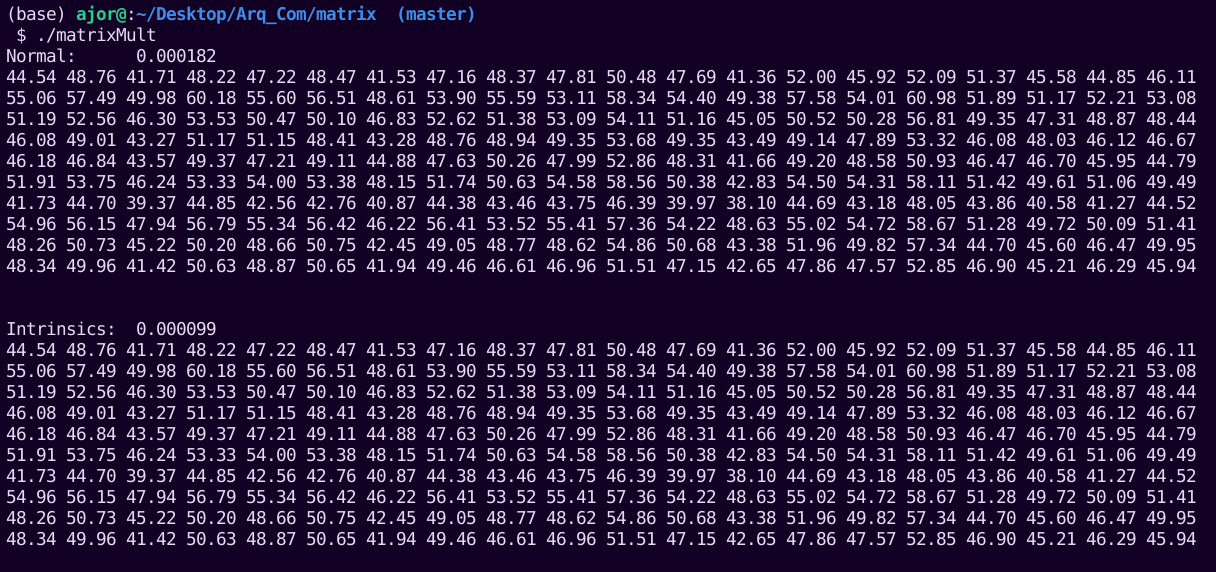
__*Figura 2.*__ Multiplicación de una matriz de 10 x127 con una de 127 x 20, usando el método normal y usando las instrucciones avx.


Como puede observarse en la Figura 2 el resultado con usando las instrucciones avx corresponde con el resultado de una multiplicación normal de matrices. También puede observarse que el tiempo de ejcución es menor con las instrucciones avx.





__*Cuadro 1.*__ Tiempo promedio de ejecuciones con distintos tamaños de matriz y distintas optimizaciones.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-1wig{font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-fymr">Banderas </th>
    <th class="tg-1wig">Método</th>
    <th class="tg-fymr">100 x 100<br>(s)</th>
    <th class="tg-fymr">200 x 200<br>(s)</th>
    <th class="tg-fymr">500 x 500<br>(s)</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-fymr" rowspan="2">Sin <br>optimizar</td>
    <td class="tg-0lax">normal</td>
    <td class="tg-0pky">0.006711</td>
    <td class="tg-0pky">0.028056</td>
    <td class="tg-0pky">0.360445</td>
  </tr>
  <tr>
    <td class="tg-0lax">intrinsics</td>
    <td class="tg-0pky">0.002412</td>
    <td class="tg-0pky">0.011014</td>
    <td class="tg-0pky">0.146878</td>
  </tr>
  <tr>
    <td class="tg-fymr" rowspan="2">-O</td>
    <td class="tg-0lax">normal</td>
    <td class="tg-0pky">0.000923</td>
    <td class="tg-0pky">0.003645</td>
    <td class="tg-0pky">0.044291</td>
  </tr>
  <tr>
    <td class="tg-0lax">intrinsics</td>
    <td class="tg-0pky">0.000164</td>
    <td class="tg-0pky">0.001077</td>
    <td class="tg-0pky">0.01557</td>
  </tr>
</tbody>
</table>

Se realizaron distintas ejecuciónes multiplicando matrices de 100 x 100, 200 x 200 y 500 x 500. Tal como se muestra en el cuadro 1. al usar las instrucciones vectoriales se obtiene una mejor en el tiempo de ejecución con respecto de la multiplicación de manera tradicional. Se promediaron 3 ejecuciones para obtener los datos presentados en el cuadro 1. Se observó que al compilar con las banderas -O2 y -O3, la multiplicación tradicional tiene un tiempo de ejecución menor al la implementación con instrucciones avx. Con la primera multiplicación de matrices de 100 x 100 se lográ obtener una aceleración de 2.78, 5.62 optimizando. En el caso una multiplicación de 2 matrices de 200 x 200 se lográ un 2.54 de aceleración y 3.38 con optimización. Finalmente para la multiplicación de matrices de tamaño 500 x 500, se obtiene una aceleración de 2.454 y 2.844 optimizando.

Por lo tanto se puede concluir que las instrucciones vectoriales incorporadas en el procesador, reducen los tiempos de ejecución en la suma y multiplicación. Al igual que la carga y almacenamiento de los datos. 